## Notebook Purpose

Provide an example of running ConvDecoder on the FastMRI dataset. Code adapted from https://github.com/MLI-lab/ConvDecoder

Note: This codebase is new and likely has bugs. If you find any, please ping vanveen@stanford.edu -- meanwhile I'll push my updated code to dev every so often. Thanks!

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

from utils.helpers import num_params, load_h5, get_masks
from include.decoder_conv import convdecoder
from include.mri_helpers import get_scale_factor, get_masked_measurements, \
                                data_consistency
from include.fit import fit
from utils.evaluate import calc_metrics
from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(3)
else:
    dtype = torch.FloatTensor

### Load measurements y and mask M

In [2]:
file_id = '1000267'
filename = '/bmrNAS/people/dvv/multicoil_val/file{}.h5'.format(file_id)

f, slice_ksp = load_h5(file_id)

mask, mask2d, mask1d = get_masks(f, slice_ksp)

### Initialize ConvDecoder

In [3]:
in_size = [8,4]
out_size = slice_ksp.shape[1:] # shape of (x,y) image slice, e.g. (640, 368)
out_depth = slice_ksp.shape[0]*2 # 2*n_c, i.e. 2*15=30 if multi-coil
num_layers = 8
strides = [1]*(num_layers-1)
num_channels = 160
kernel_size = 3

net = convdecoder(in_size, out_size, out_depth, num_layers, \
                  strides, num_channels).type(dtype)
print('# parameters of ConvDecoder:',num_params(net))

# parameters of ConvDecoder: 1850560


### Miscellaneous data conversion / pre-processing

In [4]:
# make torch versions for data consistency step in fit()
mask1d_ = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) 
ksp_orig = np_to_tt(split_complex_vals(slice_ksp)) # ([15, 640, 368, 2]); slice_ksp (15,640,368) complex

# generate network input
# fix scaling b/w original image and network output
scale_factor, net_input = get_scale_factor(net,
                                   num_channels,
                                   in_size,
                                   slice_ksp)
slice_ksp = slice_ksp * scale_factor

### Apply mask

In [5]:
ksp_masked, img_masked = \
        get_masked_measurements(slice_ksp, mask)

### Fit network

In [6]:
NUM_ITER = 1000

net, mse_wrt_ksp, mse_wrt_img = fit(
    ksp_masked=ksp_masked, img_masked=img_masked,
    net=net, net_input=net_input, mask2d=mask2d,
    mask1d=mask1d_, ksp_orig=ksp_orig,
    img_ls=None, num_iter=NUM_ITER, dtype=dtype)

### Compute network output, perform data consistency step

In [7]:
img_out = net(net_input.type(dtype))[0] # \hat{x} = G(\hat{C})

img_dc, img_est = data_consistency(img_out, slice_ksp, mask1d)

### Reconstruct ground-truth

In [8]:
img_gt = recon_ksp_to_img(slice_ksp)

### Plot results

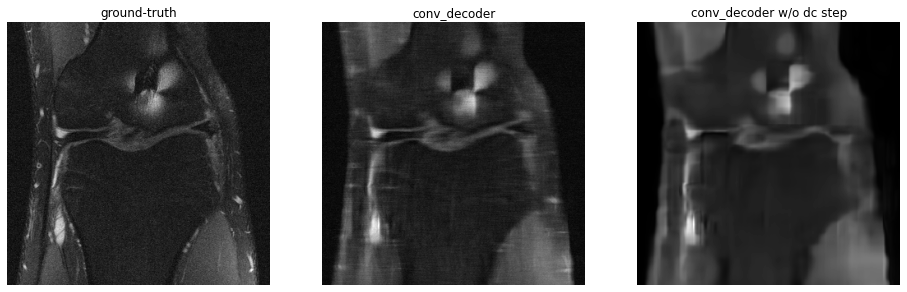

In [9]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(131)
ax1.imshow(img_gt, cmap='gray')
ax1.set_title('ground-truth')
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.imshow(img_dc, cmap='gray')
ax2.set_title('conv_decoder')
ax2.axis('off')

ax4 = fig.add_subplot(133)
ax4.imshow(img_est, cmap='gray')
ax4.set_title('conv_decoder w/o dc step')
ax4.axis('off')

plt.show()